In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmaps

2021.07.06

水汽通量垂直积分的绘图部分

从 shumflux_vi_count.ipynb 的预存数据中读取，进行绘图

2021.07.22

修改单位为kg * m-1 * s-1

2021.08.15

修改到更大的区域上来进行绘制，并且在前一步积分过程中将NAN设置为0，消去此前的很多NAN区域

In [2]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/dyn/shum_flux/"
mod_list    = ['obs', 'vr', 'rcm']
season_list = ['am', 'jja']
# 读取水汽通量的垂直积分
uflux_vi = {}
vflux_vi = {}

for imod in mod_list:
    uflux_vi[imod]  = {}
    vflux_vi[imod]  = {}

    for iseason in season_list:
        uflux_vi[imod][iseason]  = xr.open_dataset(dir_in + "shum_uflux_"+iseason+".nc")[imod]
        vflux_vi[imod][iseason]  = xr.open_dataset(dir_in + "shum_vflux_"+iseason+".nc")[imod]

In [3]:
# 计算绘图的平均值
uflux_vi_mean = {} # 平均u方向水汽通量
vflux_vi_mean = {} # 平均v方向水汽通量
absflux_vi_mean = {} # 水汽通量大小，平均图
for imod in mod_list:
    uflux_vi_mean[imod] = {}
    vflux_vi_mean[imod] = {}
    absflux_vi_mean[imod] = {}
    for iseason in season_list:
        uflux_vi_mean[imod][iseason] = uflux_vi[imod][iseason].mean(axis=0) * 1e2 / 9.8 # 转换单位
        vflux_vi_mean[imod][iseason] = vflux_vi[imod][iseason].mean(axis=0) * 1e2 / 9.8
        absflux_vi_mean[imod][iseason] = np.sqrt(uflux_vi_mean[imod][iseason] ** 2 + vflux_vi_mean[imod][iseason] **2) 
# flux 等值线绘制大小

# 绘图部分

In [4]:
# 整理绘图所使用的坐标变量
lat  = uflux_vi['vr']['jja'].latitude
lon  = uflux_vi['vr']['jja'].longitude
time = uflux_vi['vr']['jja'].Time
time_am = uflux_vi['vr']['am'].Time
time_jja = uflux_vi['vr']['jja'].Time
# vr_uflux_sum_addcoords = xr.DataArray(vr_uflux_sum, coords=[time,lat,lon], name = "qv uflux").mean('Time')
# vr_vflux_sum_addcoords = xr.DataArray(vr_vflux_sum, coords=[time,lat,lon], name = "qv vflux").mean('Time')
# vr_flux_all = np.sqrt(vr_uflux_sum_addcoords ** 2 + vr_vflux_sum_addcoords ** 2 )

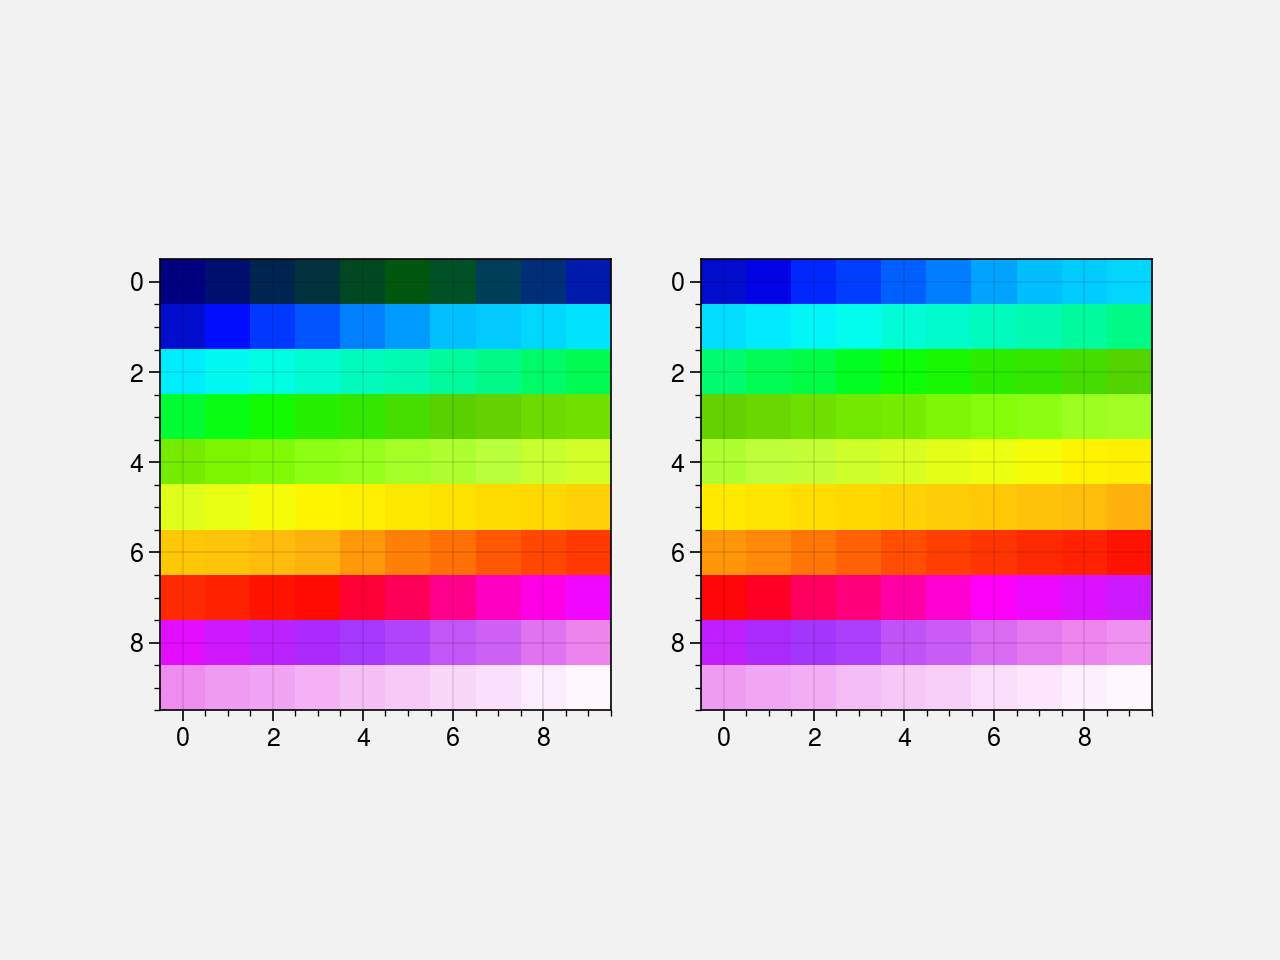

In [33]:
# 调整cmap，去掉gist_ncar 中深蓝色的部分
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cmaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_ncar')
# cmap = cmaps.GMT_wysiwygcont
# cmap = cmaps.WhiteBlueGreenYellowRed

new_cmap = truncate_colormap(cmap, 0.1, 1.)
# new_cmap = truncate_colormap(cmap, 0., 1.)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [6]:
# 国内政区图的绘制
# Load the border data, CN-border-La.dat is download from
# https://gmt-china.org/data/CN-border-La.dat
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

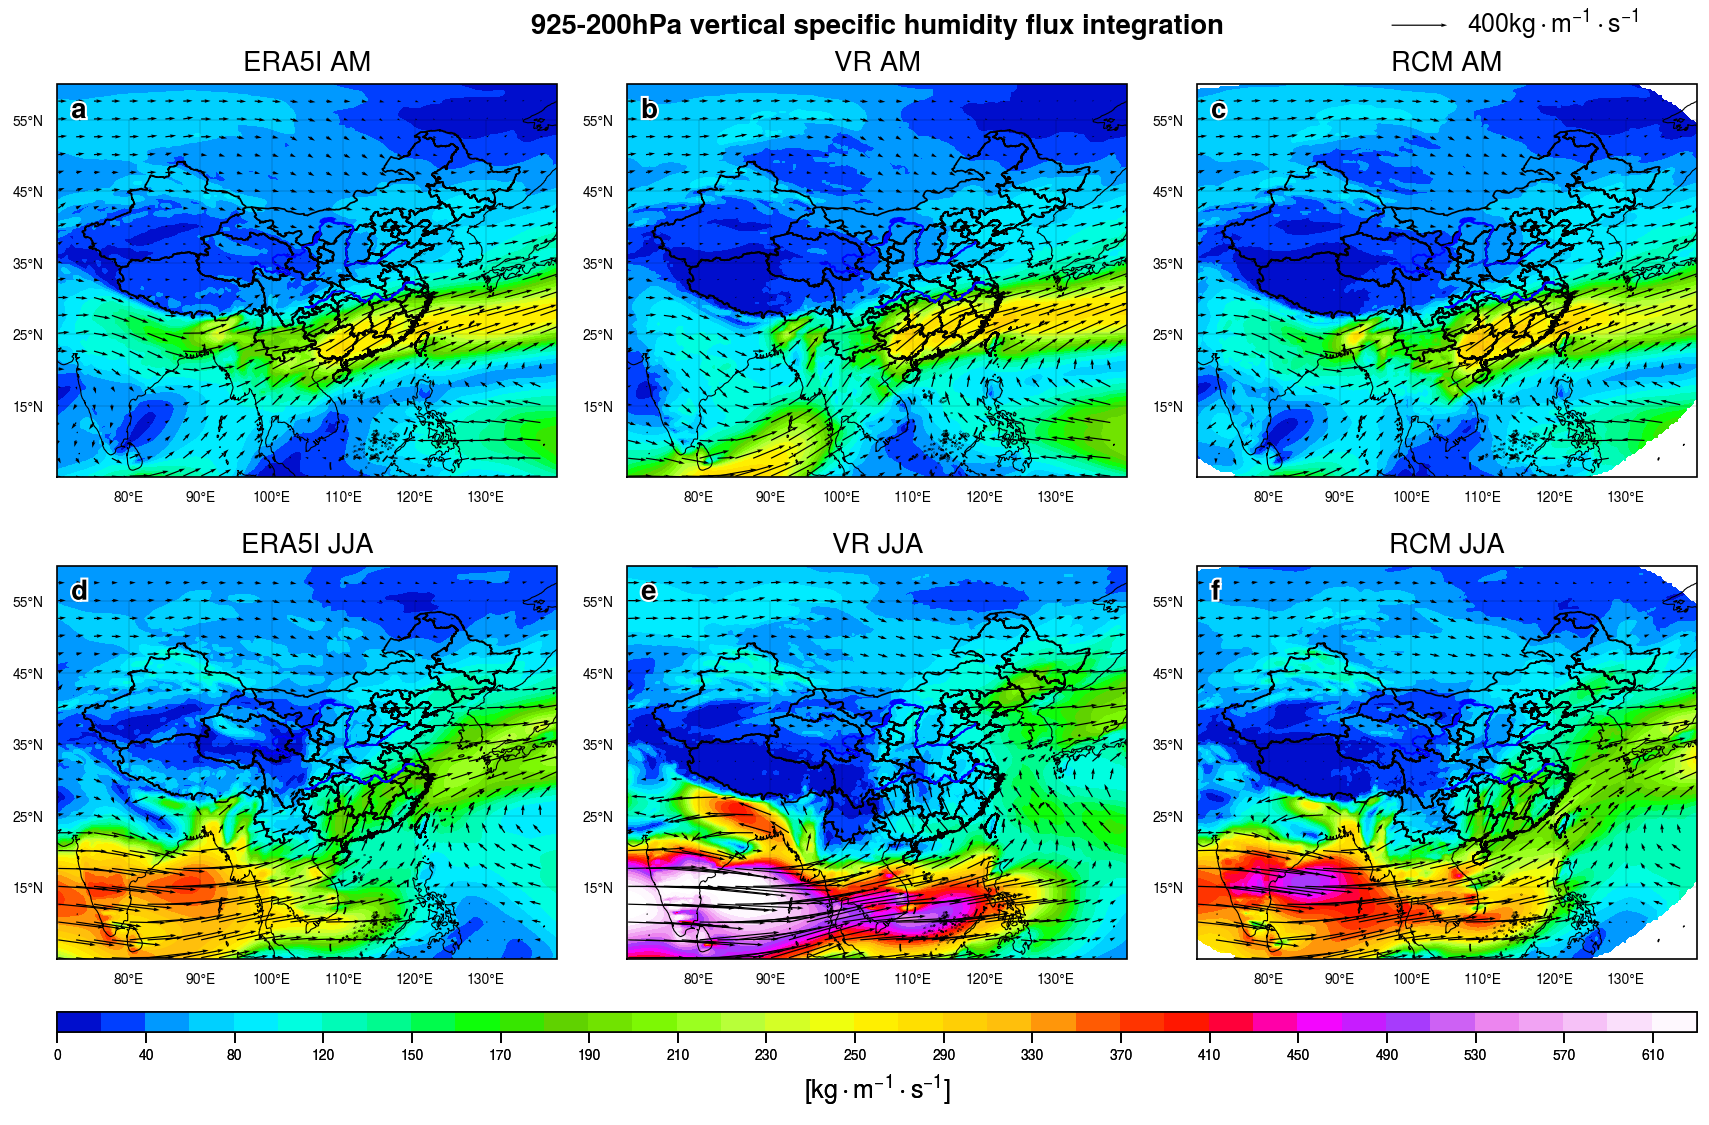

In [35]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
import cmaps

# cmap = "coolwarm"
# cmap = "gist_ncar"
cmap = new_cmap

# ----- get filter vars coords-----

# cticks = np.arange(0,700,20)
cticks = np.concatenate((plot.arange(0,140,20),plot.arange(150,250,10),plot.arange(270,640,20)))

#----- create plot -----
fig, axs = plot.subplots(ncols=3,nrows=2, proj=('cyl'))


##---- 直接绘图，从边界文件添加
turn_on_border = True
if(turn_on_border):
    # for ax_ind in axs:
    # for line in borders:
        # axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
        # axs.plot(line[0::10], line[1::10], lw = 0.4, color='black',transform=ccrs.Geodetic())
    ##---- 使用shp文件添加
        ## shapefile数据下载的位置：
    ## http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
    # world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
    river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"
    southsea_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "southsea_island.shp"
    ninelines_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "nine_lines.shp"
    ## 来源： 沛沛的诸省 + 诸岛
    bou24p_shapefile     = "/m2data2/yycheng/data_stage/CN-border/peipeihelp/" + "bou2_4p.shp"
    ## 来源： https://www.resdc.cn/data.aspx?DATAID=200
    province_shapefile     = "/m2data2/yycheng/data_stage/CN-border/CN-sheng/" + "change_proj_CN-sheng-A.shp"

    for ax in axs:
        # world     = shpreader.Reader(world_border_shapefile).geometries()
        # river     = shpreader.Reader(river_border_shapefile).geometries()
        river     = shpreader.Reader(river_border_shapefile, encoding = 'gbk')
        # bou24p    = shpreader.Reader(bou24p_shapefile).geometries()
        ninelines = shpreader.Reader(ninelines_shapefile).geometries()
        province  = shpreader.Reader(province_shapefile).geometries()
        # ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
        # ax.add_geometries(bou24p, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 沛沛map
        ax.add_geometries(province, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 地资所
        ax.add_geometries(ninelines, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1)
        # ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
        # 绘制部分的shapefile
        for region in river.records():
            if (region.attributes['NAME'] in ['黄河','长江']):
                # print("----- draw river! -----")
                # 此处需要使用 [] 让region.geometry可以迭代
                ax.add_geometries([region.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.6, zorder=1)


scale_num = 3600
#-----vr-----
axs[0].format(title='ERA5I AM')
m_contour= axs[0].contourf(lon, lat, absflux_vi_mean['obs']['am'], levels = cticks, cmap=cmap)
m_quiver = axs[0].quiver(lon[::10], lat[::10], uflux_vi_mean['obs']['am'][::10,::10], vflux_vi_mean['obs']['am'][::10,::10],scale = scale_num)

axs[1].format(title='VR AM')
m_contour= axs[1].contourf(lon, lat, absflux_vi_mean['vr']['am'], levels = cticks, cmap=cmap)
m_quiver = axs[1].quiver(lon[::10], lat[::10], uflux_vi_mean['vr']['am'][::10,::10], vflux_vi_mean['vr']['am'][::10,::10],scale = scale_num)
#-----rcm -----
axs[2].format(title='RCM AM')
m_contour= axs[2].contourf(lon, lat, absflux_vi_mean['rcm']['am'], levels = cticks, cmap=cmap)
m_quiver = axs[2].quiver(lon[::10], lat[::10], uflux_vi_mean['rcm']['am'][::10,::10], vflux_vi_mean['rcm']['am'][::10,::10],scale = scale_num)
# 矢量图 quiverkey设置
axs[2].quiverkey(m_quiver, 0.5, 1.15, label=r"$400 kg \cdot m^{-1} \cdot s^{-1}$", U=400, labelpos="E")

axs[3].format(title='ERA5I JJA')
m_contour= axs[3].contourf(lon, lat, absflux_vi_mean['obs']['jja'], levels = cticks, cmap=cmap)
m_quiver = axs[3].quiver(lon[::10], lat[::10], uflux_vi_mean['obs']['jja'][::10,::10], vflux_vi_mean['obs']['am'][::10,::10],scale = scale_num)

axs[4].format(title='VR JJA')
m_contour= axs[4].contourf(lon, lat, absflux_vi_mean['vr']['jja'], levels = cticks, cmap=cmap)
m_quiver = axs[4].quiver(lon[::10], lat[::10], uflux_vi_mean['vr']['jja'][::10,::10], vflux_vi_mean['vr']['am'][::10,::10],scale = scale_num)

axs[5].format(title='RCM JJA')
m_contour= axs[5].contourf(lon, lat, absflux_vi_mean['rcm']['jja'], levels = cticks, cmap=cmap)
m_quiver = axs[5].quiver(lon[::10], lat[::10], uflux_vi_mean['rcm']['jja'][::10,::10], vflux_vi_mean['rcm']['am'][::10,::10],scale = scale_num)


fig.colorbar(m_contour, cmap=cmap,loc='b', width=0.1,ticklabelsize=5,ticks=cticks[::2],label="[" + r"$kg \cdot m^{-1} \cdot s^{-1}$" + "]")
# format作为整个proplot集中对属性进行修改的method
axs.format(
abc=True,
abcloc = "ul",
lonlim=(70, 140), latlim=(5, 60), 
#----- 地图底图设置 -----
# reso = 'x-hi',
reso = 'med',
# coast = False,
coast = True,
coastlinewidth = 0.4,
borders = False,
lakes = False,
land  = False,
ocean = False,
# cartopyautoextent = True, 
# borderslinewidth=.5,
# borders = True,

#-----GEO axis-----
labels = True,
gridlabelsize = 5,
gridminor = False,

longrid  = True,
latgrid  = True,
# latlines = 10,
# lonlines = 10,
lonlocator = np.arange(70,150,10),
latlocator = np.arange(15,65,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(15,55+2,2),
#-----line label-----
# linewidth = 0.5,
suptitle="925-200hPa vertical specific humidity flux integration",
)
# #----- add contour tick labels -----
# # axs.clabel(m, inline=True, fontsize=5, colors = 'k', fmt='%4.0f',use_clabeltext=True, inline_spacing=0)
# fig.colorbar(m_contour, loc='b', cmap=cmap, width=0.1)

fig.patch.set_facecolor('white')
plt.savefig('./output_pic/water_flux_vi_98-17_change_unit_large.png', dpi=600, facecolor= "white")